# **LDA with priors pipeline**

# 0. Packages

In [24]:
# Core libraries
import os
import re
import sys
import ast
import csv
import math
import pickle
import subprocess
from collections import Counter
from itertools import chain
from typing import Union

# Data handling and computation
import numpy as np
import pandas as pd
from tqdm import tqdm
from tqdm import tqdm
tqdm.pandas()  # Initialize progress bars for pandas


# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import matplotlib.ticker as mticker


# NLP - NLTK
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer
from nltk.corpus import stopwords

# NLP - spaCy
import spacy

# NLP - Language detection
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException

# NLP - Vectorization & Topic Modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from gensim import corpora, models
from gensim.matutils import Sparse2Corpus

# LDA
from gensim import corpora, models
from gensim.models import LdaModel

# Statistics
from scipy import stats
from scipy.stats import pearsonr
from scipy.sparse import csr_matrix


# 1. Importing the data

## Importing Song lyrics

In [2]:

import os

os.chdir(r"C:\Users\aleja\OneDrive\Escritorio\Term_2\Text_Mining\Text_mining_final_project")
print("Current working directory:", os.getcwd())

# Songs dataset with lyrics
df = pd.read_csv(os.path.join('Spotify-Genius', 'billboard_hot_100_2004_2024_total.csv'))

df.head()

Current working directory: C:\Users\aleja\OneDrive\Escritorio\Term_2\Text_Mining\Text_mining_final_project


,year,ranking,title,artist,lyrics,song_url,producers,writers,label,released_on,tags,month,In English,Pop,Rap,R&B,Electro-Pop,Rock,usa,year_month
0,2004,1,Yeah!,Usher featuring Lil Jon and Ludacris,"[Intro: USHER & Lil Jon]\r\nPeace up, A-Town d...",https://genius.com/usher-yeah-lyrics,['Lil Jon'],"['Sean Garrett', 'Rob McDowell', 'Patrick “J. ...","['Arista Records', 'LaFace Records']","January 27, 2004","['Crunk', 'Pop Rap', 'Contemporary R&B', 'Dirt...",1,1,1,1,1,0,0,1,2004-01
1,2004,2,Burn,Usher,"[Intro]\r\nGirl, I understand why\r\nSee, it's...",https://genius.com/usher-burn-lyrics,"['Jermaine Dupri', 'Bryan-Michael Cox']","['Jermaine Dupri', 'Bryan-Michael Cox', 'USHER']","['LaFace Records', 'Arista Records']","March 21, 2004","['Soul Pop', 'USA', 'Soul', 'Pop', 'R&B', 'In ...",3,1,1,0,1,0,0,1,2004-03
2,2004,3,If I Ain't Got You,Alicia Keys,"[Intro]\r\nMm-mm\r\nMm-mm, oh\r\nMm-mm\r\n[Ver...",https://genius.com/alicia-keys-if-i-aint-got-y...,['Alicia Keys'],['Alicia Keys'],['J Records'],"February 17, 2004","['Ballad', 'R&B', 'In English', 'Soul Pop', 'U...",2,1,1,0,1,0,0,1,2004-02
3,2004,4,This Love,Maroon 5,[Verse 1]\r\nI was so high I did not recognize...,https://genius.com/maroon-5-this-love-lyrics,"['Mark Endert', 'Matt Wallace']","['Jesse Carmichael', 'Adam Levine']","['J Records', 'Octone Records']","June 25, 2002","['Alternative R&B', 'Bubblegum Pop', 'Pop-Rock...",6,1,1,0,1,0,1,1,2004-06
4,2004,5,The Way You Move,OutKast featuring Sleepy Brown,"[Intro: Big Boi]\r\nBoom, boom, boom\r\nHa-ha!...",https://genius.com/outkast-the-way-you-move-ly...,"['Big Boi', 'Carl Mo']","['Sleepy Brown', 'Big Boi', 'Carl Mo']","['Arista Records', 'LaFace Records']","September 23, 2003","['Atlanta Rap', 'In English', 'Soul Pop', 'Sou...",9,1,0,1,1,0,0,1,2004-09


## Importing Concepnet already preprocessed data

In [3]:
# Load the CSV file into a DataFrame
df_cnet = pd.read_csv(os.path.join('ConceptNet', 'concept_net_terms_preprocessed.csv'))

# 2. Cleaning the data

## Importing functions

In [4]:
# Define preprocessing function
def preprocess_lower(text, rm_stopwords = False, stopword_set = None):
    """
    Preprocess text by:
       - Converting to lowercase.
       - Removing punctuation and digits.
       - Tokenizing.
       - Removing stopwords (optional).
    
    Returns:
        list: A list of tokens lowercased and without punctuation.
    """
    text_lower = text.lower()
    text_no_punct = re.sub(r'[^a-zA-Z\s]', ' ', text_lower)  # Remove digits and punctuation, replace by whitespace
    tokens = word_tokenize(text_no_punct)
    tokens = word_tokenize(text_no_punct)
    # Remove stopwords if desired
    if rm_stopwords == True:
        tokens = [token for token in tokens if token not in stopword_set]
    # We return the whole string of tokens so that we can find n-grams later
    return " ".join(tokens)

# Define stopwords
my_stop_words = set(stopwords.words('english'))

# Create set of custom stopwords (optional)
my_custom_stopwords = {'intro', 'verse', 'chorus', 'bridge'} 

# Update stopwords (optional)
my_stop_words.update(my_custom_stopwords)

my_stop_words = set(stopwords.words('english'))

In [5]:
def preprocess_lemmatize(text):
    """
    Preprocess text by applying lemmatized.
    Should just input a string which has been previously pre-processed, which at least removes
    the punctuation.

    Returns:
        str: A string of lemmatized tokens separated by spaces.
    """

    tokens = text.split()  # Split input text based on whitespaces
    lemmatizer = WordNetLemmatizer()  # Initiallize lemmatizer
    lemmatized_text = []  # Initialize empty list to store lemmatized text
    for word in tokens:
        lemmatized_text.append(lemmatizer.lemmatize(word))

    return " ".join(lemmatized_text)

## Tokenizing and stopword removal

In [6]:
# Apply the preprocessing function to the 'lyrics' column
df['lyrics_lower'] = df['lyrics'].apply(
    lambda row: preprocess_lower(text=row, rm_stopwords=True, stopword_set=my_stop_words)
)

## Lemmatizing

In [7]:
df['lyrics_lemmatized'] = df['lyrics_lower'].progress_apply(
    lambda row: preprocess_lemmatize(text = row)
    )

100%|██████████| 2092/2092 [00:02<00:00, 892.72it/s] 


# LDA with priors

In [8]:
# Create a dictionary where keys are input_term values
# and values are lists of (label_lower, weight_normalized) tuples
input_term_dict = {
    term: list(df_cnet[df_cnet['input_term'] == term][['label_lower', 'weight_normalized']].itertuples(index=False, name=None))
    for term in df_cnet['input_term'].unique()
}

In [9]:
# Input term dictionary
for k, v in input_term_dict.items():
    print(f"{k}: {v}")


health: [('well', 8.892176439312824), ('wellbeing', 7.38661714350238), ('condition', 7.38661714350238), ('good', 7.328835083130087), ('well', 6.805397595051658), ('body', 6.11201287058413), ('healthiness', 3.9876724157203793), ('sanidad', 3.9876724157203793), ('heartiness', 3.9876724157203793), ('malfunction', 3.9876724157203793), ('toast', 3.9876724157203793), ('everyone', 3.9876724157203793), ('function', 3.9876724157203793), ('mental', 3.9876724157203793), ('video games', 3.9876724157203793), ('prosperity', 3.9876724157203793), ('organism', 3.9876724157203793), ('physical', 3.9876724157203793), ('whole', 3.9876724157203793), ('heal', 3.9876724157203793), ('salud', 3.9876724157203793), ('social', 3.9876724157203793), ('illness', 3.9876724157203793), ('state', 3.9876724157203793), ('disease', 3.9876724157203793), ('sickness', 3.9876724157203793), ('robustness', 3.9876724157203793), ('important', 3.9876724157203793), ('psychological', 3.9876724157203793), ('wellness', 3.987672415720379

In [10]:
# Creating DTM
cv = CountVectorizer(ngram_range = (1,3), lowercase=False, max_df=0.9)
cv.fit(df.lyrics_lemmatized)
vectorized_text=cv.transform(df.lyrics_lemmatized)
vectorized_text=vectorized_text.toarray()
print("document term matrix has size", vectorized_text.shape)

document term matrix has size (2092, 276215)


In [11]:
# Convert the document-term matrix to sparse format
dtm_sparse = csr_matrix(vectorized_text)

# Convert sparse matrix to Gensim corpus
corpus = Sparse2Corpus(dtm_sparse, documents_columns=False)

# Create Gensim dictionary from sklearn CountVectorizer vocabulary
vocabulary_gensim = {val: key for key, val in cv.vocabulary_.items()}  # inverse mapping
dictionary = corpora.Dictionary()
dictionary.id2token = vocabulary_gensim
dictionary.token2id = cv.vocabulary_

# Function to build custom eta matrix using input_term_dict (terms only, no weights)
def build_eta_matrix_from_weights_cv(input_term_dict, dictionary, base_eta=0.01, boost_eta=0.5):
    """
    Builds a custom eta matrix for Gensim LDA using input_term_dict (terms only, no weights).
    
    Parameters:
    - input_term_dict: dict {topic_id (int): list of seed words}
    - dictionary: Gensim Dictionary created from CountVectorizer.vocabulary_
    - base_eta: default prior value for all word-topic pairs
    - boost_eta: value for boosting seed words in their respective topics
    
    Returns:
    - eta matrix: (num_topics x vocab_size)
    """
    num_topics = len(input_term_dict)
    vocab_size = len(dictionary)
    eta = np.full((num_topics, vocab_size), base_eta)

    for topic_id, word_list in enumerate(input_term_dict.values()):  # assign integer topic_id automatically
        for word in word_list:
            if word in dictionary.token2id:
                word_id = dictionary.token2id[word]
                eta[topic_id, word_id] = boost_eta

    return eta

# Build eta matrix from your input_term_dict
eta = build_eta_matrix_from_weights_cv(
    input_term_dict=input_term_dict,
    dictionary=dictionary,
    base_eta=0.01,
    boost_eta=0.5
)

# Set number of topics to match your dictionary
num_topics = len(input_term_dict)

# Train the LDA model
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    alpha='auto',
    eta=eta,
    passes=10,
    random_state=42
)

# Display topics
topics = lda_model.print_topics(num_words=50)
for topic in topics:
    print(topic)
    print("")

# Get document-topic distributions
doc_topics = [lda_model.get_document_topics(item, minimum_probability=0.0000001) for item in corpus]


# Optional: structured topic-word tuples
topics = lda_model.show_topics(num_topics=-1, num_words=50, formatted=False)


(0, '0.009*"yeah" + 0.008*"da" + 0.008*"fuck" + 0.007*"te" + 0.007*"jingle" + 0.006*"da da" + 0.006*"stop" + 0.006*"bell" + 0.006*"jingle bell" + 0.006*"bitch" + 0.005*"da da da" + 0.005*"ha" + 0.005*"que" + 0.004*"club" + 0.004*"la" + 0.004*"stop stop" + 0.004*"fuck club" + 0.004*"back" + 0.004*"ha ha" + 0.004*"kiss" + 0.003*"yeah yeah" + 0.003*"yo" + 0.003*"stop stop stop" + 0.003*"oh" + 0.003*"ha ha ha" + 0.003*"ho" + 0.003*"got" + 0.003*"time" + 0.003*"intro" + 0.003*"christmas" + 0.003*"know" + 0.003*"nicki" + 0.003*"mi" + 0.003*"like" + 0.003*"si" + 0.003*"let" + 0.003*"flocka" + 0.002*"pa" + 0.002*"kiss kiss" + 0.002*"minaj" + 0.002*"nicki minaj" + 0.002*"lo" + 0.002*"guess" + 0.002*"guess back" + 0.002*"around" + 0.002*"take" + 0.002*"se" + 0.002*"foot" + 0.002*"fuck fuck" + 0.002*"man"')

(1, '0.019*"oh" + 0.016*"na" + 0.011*"oh oh" + 0.010*"good" + 0.010*"wan na" + 0.010*"wan" + 0.009*"huh" + 0.008*"huh huh" + 0.007*"oh oh oh" + 0.007*"huh huh huh" + 0.006*"love" + 0.006*"yea

## Time series Plot

In [12]:
# Assuming df is your existing DataFrame
# Ensure it has the same number of rows as the length of doc_topics

# Initialize the columns for each topic with default value 0
for topic_num in range(5):
    df[f'topic_{topic_num}'] = 0.0

# Iterate over the document topics to fill the DataFrame
for i, doc_distribution in enumerate(doc_topics):
    for topic_num, prob in doc_distribution:
        df.at[i, f'topic_{topic_num}'] = prob

# df now contains the topic distributions for each document

In [13]:
# Aggregating topic shares
alpha_prior = lda_model.alpha
total_alpha_prior = sum(alpha_prior)  # This is useful for later calculations
print("Alpha prior:", alpha_prior)
print("Total alpha prior:", total_alpha_prior)

Alpha prior: [0.04612203 0.11280564 0.21625556 0.10160032 0.05956223]
Total alpha prior: 0.5363457798957825


In [14]:
# Create a new column 'word_count' by counting the number of words in each preprocessed text
df["word_count"] = df["lyrics_lemmatized"].apply(lambda x: len(x.split()))

# Drop rows where the word count is less than 10
df = df[df["word_count"] >= 10]

In [15]:
# For each topic column, calculate the words attributed to that topic
for i in range(5):
    df[f'words_topic_{i}'] = df[f'topic_{i}'] * df['word_count']

In [17]:
# Create a new column combining year and month (as string, like '2023-03')
df['year_month'] = df['year'].astype(str) + '-' + df['month'].astype(str).str.zfill(2)

# Prepare the data for aggregation
aggregation_data = df[['year_month'] + [f'words_topic_{i}' for i in range(5)]]

# Group by year_month and sum the word counts for topics
grouped_data = aggregation_data.groupby(['year_month']).sum().reset_index()

# Adjust weights using the prior
pweight = 1
for i in range(5):
    grouped_data[f'topic_share_{i}'] = (
        grouped_data[f'words_topic_{i}'] + pweight * alpha_prior[i]
    ) / (grouped_data[[f'words_topic_{j}' for j in range(5)]].sum(axis=1) + pweight * total_alpha_prior)

# Select the final output columns
final_columns = ['year_month'] + [f'topic_share_{i}' for i in range(5)]
result_df = grouped_data[final_columns]


In [ ]:
result_df.head()

,year_month,topic_share_0,topic_share_1,topic_share_2,topic_share_3,topic_share_4
0,2004-01,0.003958,0.110608,0.719669,0.150503,0.015262
1,2004-02,0.072161,0.134130,0.554360,0.161464,0.077884
2,2004-03,0.036168,0.151771,0.769966,0.034408,0.007686
3,2004-04,0.023194,0.285899,0.667477,0.006830,0.016599
4,2004-05,0.079580,0.197769,0.616615,0.051735,0.054300


C:\Users\aleja\AppData\Local\Temp\ipykernel_12272\2033913147.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['year_month'] = pd.to_datetime(result_df['year_month'], format='%Y-%m')


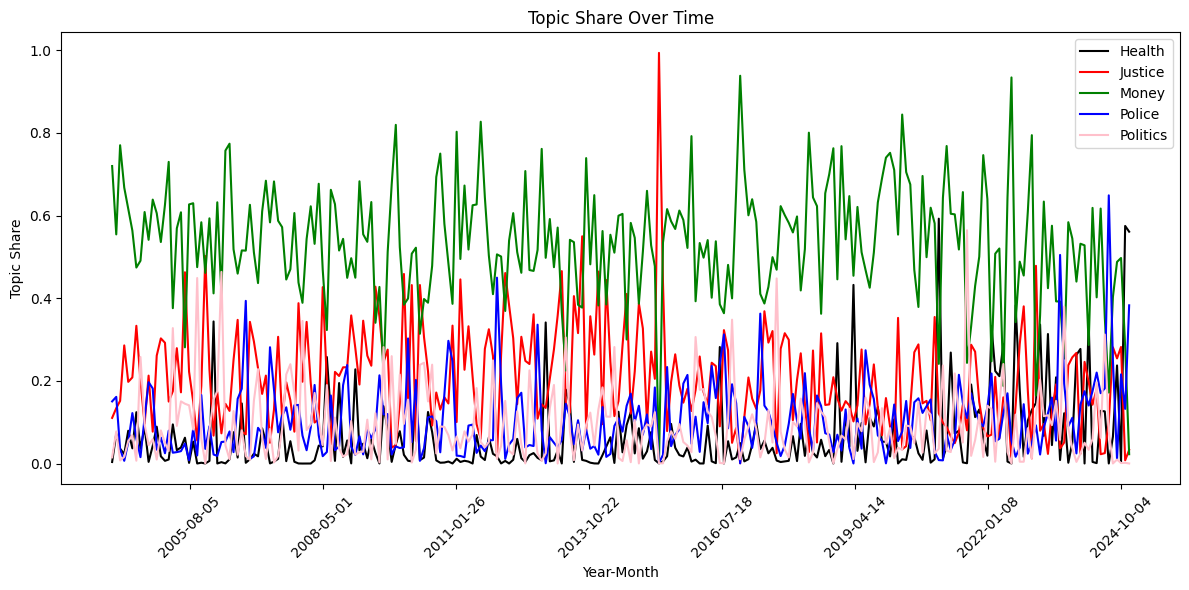

In [20]:
# Ensure year_month is datetime (if not already)
result_df['year_month'] = pd.to_datetime(result_df['year_month'], format='%Y-%m')

# Plotting
plt.figure(figsize=(12, 6))

# Plot each topic share over time
plt.plot(result_df['year_month'], result_df['topic_share_0'], label='Health', color='black')
plt.plot(result_df['year_month'], result_df['topic_share_1'], label='Justice', color='red')
plt.plot(result_df['year_month'], result_df['topic_share_2'], label='Money', color='green')
plt.plot(result_df['year_month'], result_df['topic_share_3'], label='Police', color='blue')
plt.plot(result_df['year_month'], result_df['topic_share_4'], label='Politics', color='pink')

# Formatting X-axis
plt.xticks(rotation=45)
ax = plt.gca()
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))  # Optional: remove if messy with datetimes

# Add labels and title
plt.xlabel('Year-Month')
plt.ylabel('Topic Share')
plt.title('Topic Share Over Time')
plt.legend()

# Adjust layout
plt.tight_layout()
plt.show()


# Comparison with Google Trends Data

## Importing clean Google Trends Data

In [21]:
df_gt = pd.read_csv(os.path.join('google_trends', 'multiTimeline.csv'), skiprows = 2)

df_gt = df_gt.rename(columns = {'health: (United States)': 'Health',
                                'money: (United States)': 'Money',
                                'justice: (United States)': 'Justice',
                                'police: (United States)': 'Police',
                                'politics: (United States)': 'Politics'})

df_gt.head()

,Month,Health,Money,Justice,Police,Politics
0,2004-01,82,30,10,31,4
1,2004-02,80,29,11,28,5
2,2004-03,79,30,10,30,5
3,2004-04,79,30,11,29,5
4,2004-05,74,28,9,29,4


In [22]:
# Renamming LDA for easy plotting
result_df = result_df.rename(columns={
    'topic_share_0': 'Health',
    'topic_share_1': 'Justice',
    'topic_share_2': 'Money',
    'topic_share_3': 'Police',
    'topic_share_4': 'Politics'
})

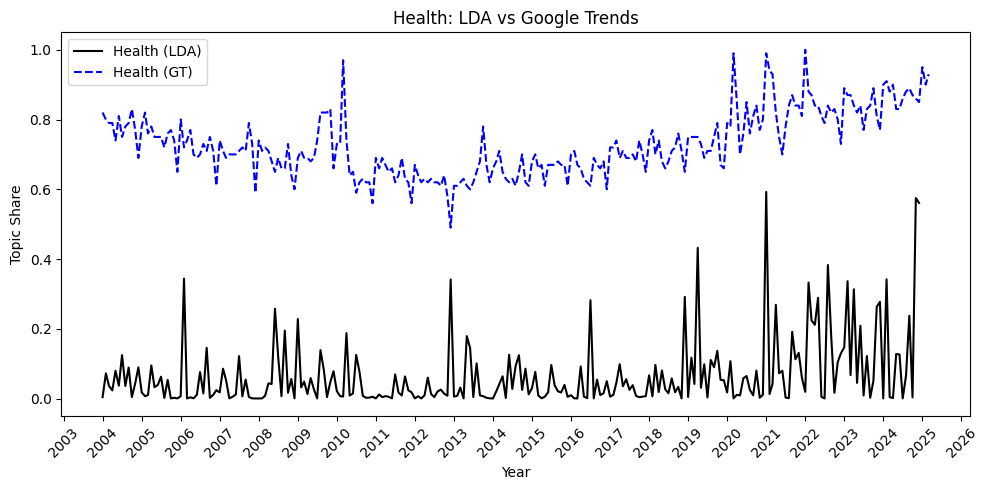

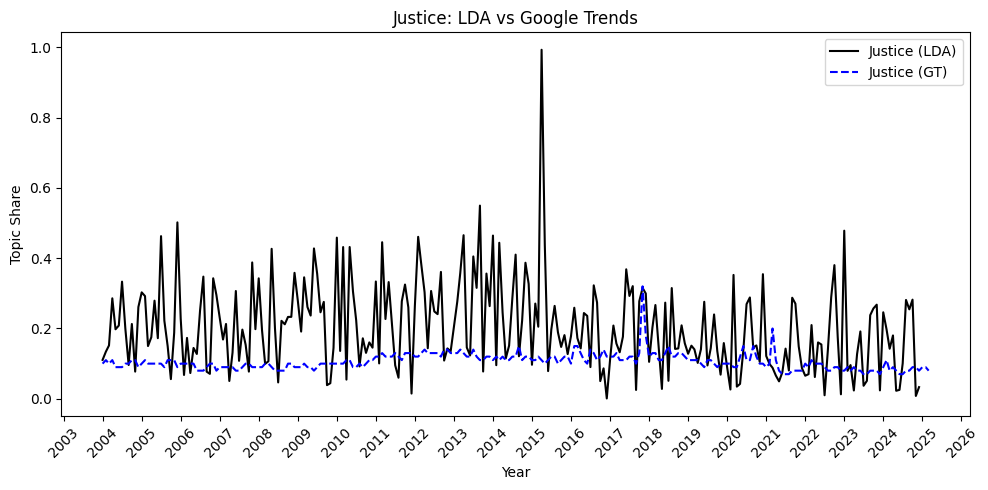

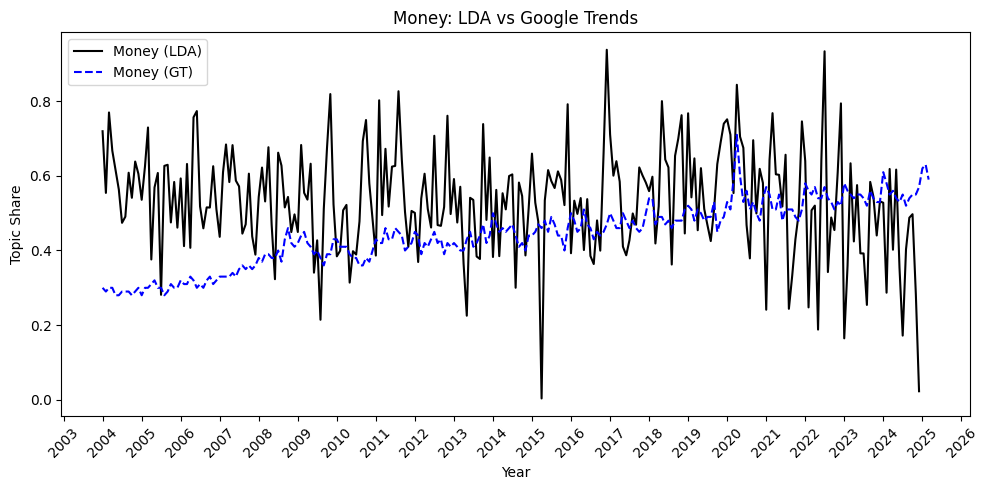

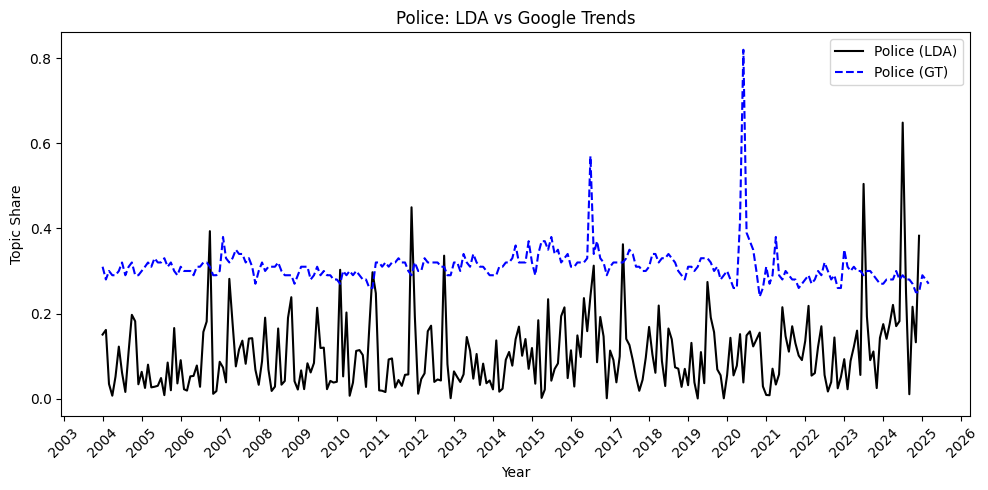

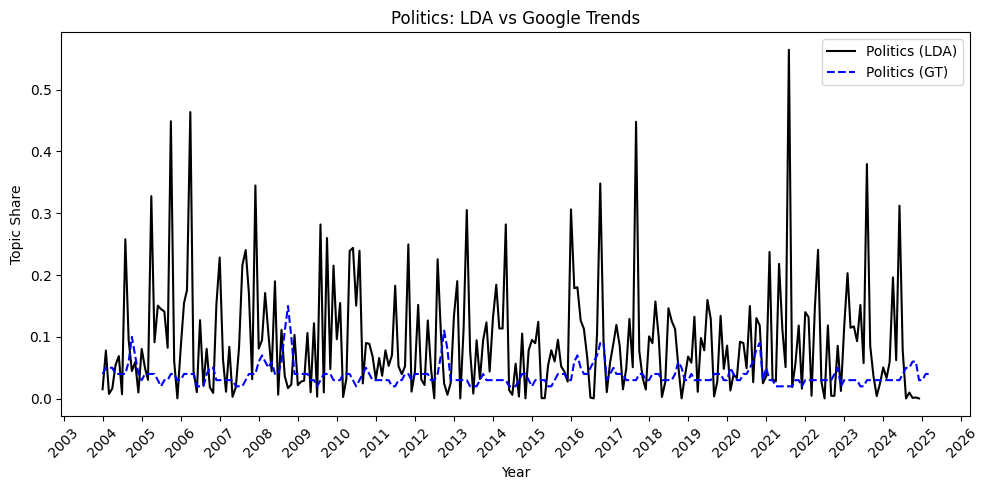

In [30]:
# Create the output directory if it doesn't exist
output_dir = os.path.join('LDA_Priors', 'graphs')
os.makedirs(output_dir, exist_ok=True)

# Ensure datetime format
result_df['year_month'] = pd.to_datetime(result_df['year_month'], format='%Y-%m')
df_gt['Month'] = pd.to_datetime(df_gt['Month'], format='%Y-%m')

# Common topic list
topics = ['Health', 'Justice', 'Money', 'Police', 'Politics']

# Loop through topics
for topic in topics:
    plt.figure(figsize=(10, 5))
    
    # Plot LDA data
    plt.plot(result_df['year_month'], result_df[topic], label=f'{topic} (LDA)', color='black')
    
    # Plot Google Trends data
    plt.plot(df_gt['Month'], df_gt[topic] / 100, linestyle='--', label=f'{topic} (GT)', color='blue')

    # Formatting
    plt.title(f'{topic}: LDA vs Google Trends')
    plt.xlabel('Year')
    plt.ylabel('Topic Share')
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    
    # Save plot
    filename = os.path.join(output_dir, f'{topic}_month.png')
    plt.savefig(filename, dpi=300)
    
    # Show plot on screen
    plt.show()